In [105]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import time
import os, shutil, sys, time, re, glob, csv
from PIL import Image
import itertools

%matplotlib inline

import face_detector

caffe_root = '/Users/anmolsinghsuag/Downloads/caffe2/' 
import sys
sys.path.insert(0, caffe_root + 'python')
import caffe

plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

categoriesEitW = [ 'Angry' , 'Disgust' , 'Fear' , 'Happy'  , 'Neutral' ,  'Sad' , 'Surprise']
#The code doesn't include datasets

(256, 256, 3)
[[ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]
 ..., 
 [ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]]


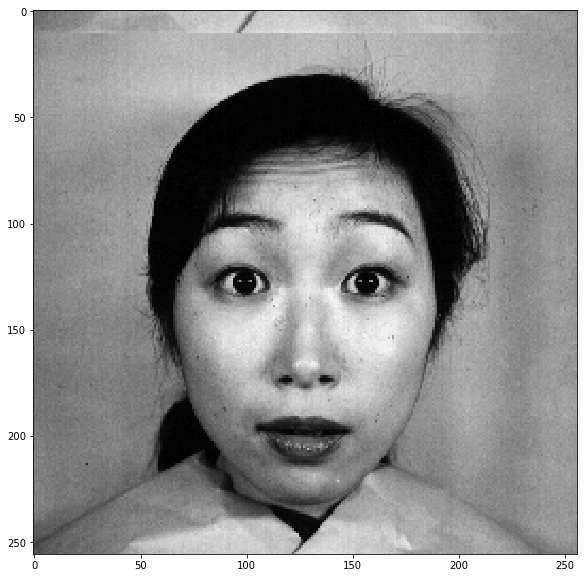

In [106]:
#Phase 1.1 : Exploring Dataset
#Dataset contains JAFFE,CK+ and Custom dataset of web-cam pictures

#Exploring JAFFE sample image
sampleJaffe = cv2.imread('datasets/KA.SU2.37.tiff')
plt.imshow(sampleJaffe)
print sampleJaffe.shape
print sampleJaffe[:,:,0] == sampleJaffe[:,:,2]

In [107]:
#Jaffe Images are 256*256 with 3 channels of same value. Faces are not cropped to face bounding box

(490, 640, 3)
[[ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]
 ..., 
 [ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]]


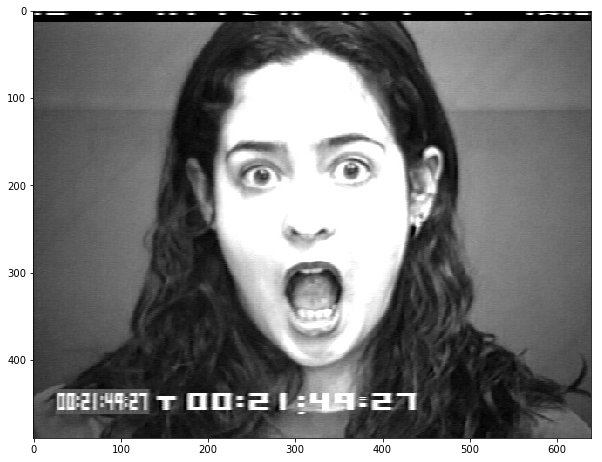

In [108]:
#Exploring Sample CK+ Image
sampleCK = cv2.imread('datasets/S080_001_00000012.png')
plt.imshow(sampleCK)
print sampleCK.shape
print sampleCK[:,:,0] == sampleCK[:,:,1]

In [109]:
#CK+ Images are 490*640 with 3 channels of same value. Faces are not cropped to face bounding box

(394, 394, 3)
[[False False False ..., False False False]
 [False False False ..., False False False]
 [False False False ..., False False False]
 ..., 
 [False False False ..., False False False]
 [False False False ..., False False False]
 [False False False ..., False False False]]


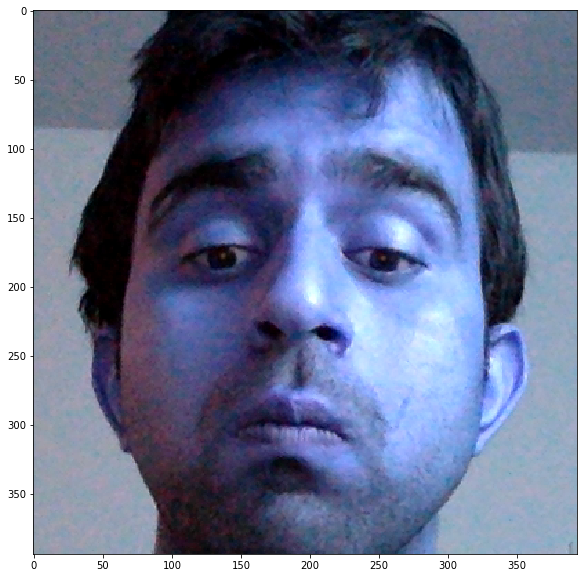

In [110]:
#Exploring Sample Custom Image
sampleCustom = cv2.imread('datasets/0000304.FE.0.png')
plt.imshow(sampleCustom)
print sampleCustom.shape
print sampleCustom[:,:,0] == sampleCustom[:,:,1]

In [111]:
#Custom images aren't cropped to face bounding box yet, channels are different, sizes are 394*394
#Colors appear to have been switched between RGB to GRB

In [112]:
#Converts RGB to BGR or vice-versa
def toggleRGB(img):
    r,g,b = cv2.split(img)
    img = cv2.merge([b,g,r])
    return img

#Converts to single channel gray
def convertToGray(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

#Copies single channel to 3 channels
def threeChannel(img):
    return cv2.merge([img,img,img])

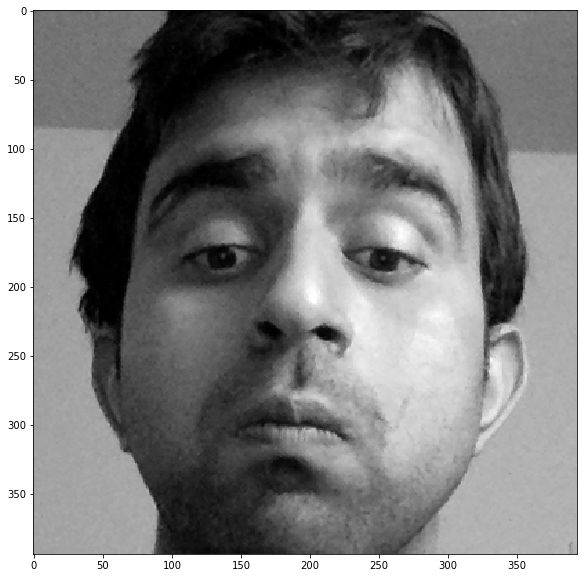

In [113]:
#Need to convert Colored images to grayscale to meet JAFFE and CK+ which are grayscale
sampleCustom = toggleRGB(sampleCustom)
sampleCustom = convertToGray(sampleCustom)
plt.imshow(sampleCustom)

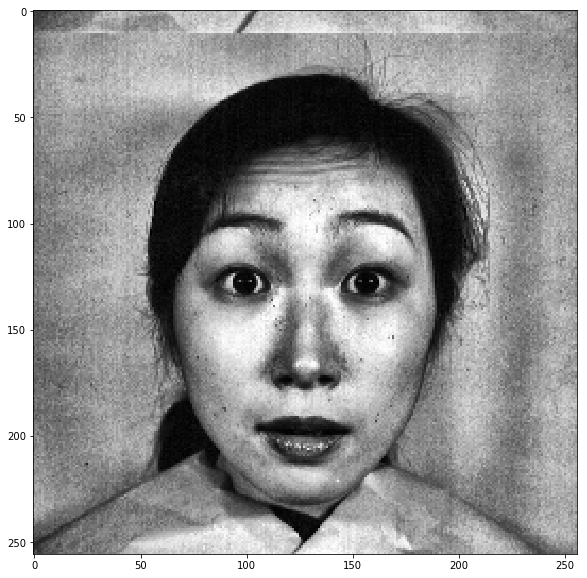

In [114]:
#Phase 1.2 : Data-Preprocessing

#Steps: Read -->Convert to GrayScale --> Find Face Bounding BOX -->CLAHE --> CROP -->Resize

#Applying CLAHE (Contrast Limited Adaptive Histogram Equalization) on image
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
sampleJaffe = convertToGray(sampleJaffe)
cl1 = clahe.apply(sampleJaffe)
plt.imshow(cl1)


In [115]:
# Setting up face cropping CNN (MTCNN Pretrained)
# Face Detector Model
threshold = [0.6, 0.7, 0.7]
factor = 0.709
minsize = 100
caffe_model_path="face_detector_models"
caffe.set_mode_cpu()
PNet = caffe.Net(caffe_model_path+"/det1.prototxt", caffe_model_path+"/det1.caffemodel", caffe.TEST)
RNet = caffe.Net(caffe_model_path+"/det2.prototxt", caffe_model_path+"/det2.caffemodel", caffe.TEST)
ONet = caffe.Net(caffe_model_path+"/det3.prototxt", caffe_model_path+"/det3.caffemodel", caffe.TEST)

In [116]:
#Finds one face in the image and returns the cropped face of size 256*256
def cropFaceAndResize(img):
    boundingboxes, _ = face_detector.detect_face(img, minsize, PNet, RNet, ONet, threshold, True, factor)
    if len(boundingboxes)==0:
        return None
    x1 = int(boundingboxes[0][0])
    y1 = int(boundingboxes[0][1])
    x2 = int(boundingboxes[0][2])
    y2 = int(boundingboxes[0][3])
    xd = int((x2-x1)*0.1)
    yd = int((y2-y1)*0.1)
    x1 = x1+xd
    x2 = x2-xd
    y1 = y1+yd
    y2 = y2-yd
    accuracy = boundingboxes[0][4]
    imgCopy = img.copy()
    cropped_img = imgCopy[y1:y2, x1:x2]
    cropped_resized_img = cv2.resize(cropped_img, (256, 256))
    return cropped_resized_img


In [117]:
# Extract all photos in CK+ and change to Jaffe format
# CK+ Images don't have well defined neutral so I ignore that, it has another label "Contempt" which I replace with "Disgust"
def convertCKToJaffeFormat():
    categoriesCK = ['Angry', 'Contempt', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise']
    categories = [ 'Angry' , 'Disgust' , 'Fear' , 'Happy'  , 'Neutral' ,  'Sad' , 'Surprise']
    dirImages = 'datasets/CKPlus/CKPlus_Images'
    dirLabels = 'datasets/CKPlus/CKPlus_Labels'
    imageFiles = glob.glob(dirImages + '/*/*/*.png')
    labelFiles = glob.glob(dirLabels + '/*/*/*.txt')
    allLabeledImages = []

    for label in labelFiles:
        img = label.replace(dirLabels,dirImages)
        img = img.replace('_emotion.txt','.png')
        allLabeledImages.append(img)

    labeledImages = []
    labels = []
    labelNames = []
    contemptImages = []

    for ind in range(len(labelFiles)):
        curLabel = labelFiles[ind]
        curImage = allLabeledImages[ind]
        with open(curLabel, 'rb') as csvfile:
            rd = csv.reader(csvfile)
            stri = rd.next()
            numCK = int(float(stri[0]))
            labelText = categoriesCK[numCK-1]
            if labelText != 'Contempt':
                numEitW = categories.index(labelText)
                labeledImages.append(curImage)
                labels.append(numEitW)
                labelNames.append(labelText)
            else:
                numEitW = categories.index("Disgust")
                labeledImages.append(curImage)
                labels.append(numEitW)
                labelNames.append(labelText)
    return labels,labeledImages

In [118]:
#Importing CK+ images, applying CLAHE (Contrast Limited Adaptive Histogram Equalization)
#Saving bounding box with resizing
def preprocessCK(labeledImages,labels):
    targetDirCk = 'datasets/ck_processed'
    suffixes   = ['AN',      'DI',       'FE',    'HA',      'NE',        'SA',   'SU']

    for i in range(len(labels)):
        image = cv2.imread(labeledImages[i])
        fname, ext = os.path.splitext(labeledImages[i])
        image_c = cropFaceAndResize(image)
        image_c = toggleRGB(image_c)
        image_c = convertToGray(image_c)
        cl1 = clahe.apply(image_c)
        cl1 = threeChannel(cl1)
        save_name = targetDirCk + '/' + fname.split('/')[-1] + '_crop.' + suffixes[labels[i]]+ ext
        Image.fromarray(cl1).save(save_name)

In [119]:
# Preprocessing Jaffe
def preprocessJaffe():
    imgList = glob.glob('datasets/jaffe'+'/*')
    labels = None
    jaffe_categories_map = {
                'HA': categories.index('Happy'),
                'SA': categories.index('Sad'),
                'NE': categories.index('Neutral'),
                'AN': categories.index('Angry'),
                'FE': categories.index('Fear'),
                'DI': categories.index('Disgust'),
                'SU': categories.index('Surprise')
                }

    labels = []

    for img in imgList:
        if os.path.isdir(img):
            continue
        key = img.split('.')[1][0:2]
        labels.append(jaffe_categories_map[key])
    
    targetDirJaffe = 'datasets/jaffe_processed'
    for i in range(len(labels)):
        image = cv2.imread(imgList[i])
        fname, ext = os.path.splitext(imgList[i])
        image_c = cropFaceAndResize(image)
        image_c = toggleRGB(image_c)
        image_c = convertToGray(image_c)
        cl1 = clahe.apply(image_c)
        cl1 = threeChannel(cl1)
        save_name = targetDirJaffe + '/' + fname.split('/')[-1] + '_crop.' + suffixes[labels[i]]+ ext
        Image.fromarray(cl1).save(save_name)

In [120]:
#Preprocessing Home brewed images
def preprocessCustom():
    targetDirJaffe = 'datasets/suag_processed'
    imgList = glob.glob('datasets/Suag'+'/*')
    for i in range(len(imgList)):
        image = cv2.imread(imgList[i])
        fname, ext = os.path.splitext(imgList[i])
        image_c = cropFaceAndResize(image)
        if(image_c is None):
            continue
        image_c = toggleRGB(image_c)
        image_c = convertToGray(image_c)
        cl1 = clahe.apply(image_c)
        cl1 = threeChannel(cl1)
        save_name = targetDirJaffe + '/' + fname.split('/')[-1] + "."+fname.split('/')[-1].split('.')[1]+ ext
        Image.fromarray(cl1).save(save_name)

In [121]:
#labels,labeledImages = convertCKToJaffeFormat()
#preprocessCK(labeledImages,labels)
#preprocessJaffe()
#preprocessCustom()
#len(labels)
#There are 327 Images in CK+

In [122]:
# After processing we are left with 631 custom images, 214 Jaffe Images and 328 CK+ images.
# Dividing 80-20 for Train - Test

In [123]:
categoriesEitW = [ 'Angry' , 'Disgust' , 'Fear' , 'Happy'  , 'Neutral' ,  'Sad' , 'Surprise']

jaffe_categories_map = {
    'HA': categoriesEitW.index('Happy'),
    'SA': categoriesEitW.index('Sad'),
    'NE': categoriesEitW.index('Neutral'),
    'AN': categoriesEitW.index('Angry'),
    'FE': categoriesEitW.index('Fear'),
    'DI': categoriesEitW.index('Disgust'),
    'SU': categoriesEitW.index('Surprise')
    }

def get_label(fname):
    label = fname.split('.')[-2]
    return str(jaffe_categories_map[label])

In [124]:
#Creates Test,Validation and Train Text files for caffe
def createDataFile(kind):
    f = open('datasets/'+kind+'_list.txt', 'w')
    dir = 'datasets/'+kind+'_images/'
    imgList = glob.glob(dir+'*.png') + glob.glob(dir+'*.tiff')

    for img in imgList:
        if os.path.isdir(img):
            continue
        label = get_label(img)
        fname = img.split('/')[2]
        f.write(fname + ' ' + label + '\n')
    f.close()

In [125]:
#createDataFile("testing")
#createDataFile("validation")
#createDataFile("training")

In [126]:
#Phase 1.3 : Finetuning Pretrained VGG_S on new Train Dataset
#Network is trained in Caffe that outputs logs into a log.txt file and creates a .caffemodel

In [127]:
#Phase 1.4 : Checking Training history, accuracies, confusion

#Loads the trained Network
def loadNet(modelDir,dataDir,currNetDir,modelName):
    mean_filename=os.path.join(dataDir,'mean_training_image.binaryproto')
    proto_data = open(mean_filename, "rb").read()
    a = caffe.io.caffe_pb2.BlobProto.FromString(proto_data)
    mean  = caffe.io.blobproto_to_array(a)[0]
    net_pretrained = os.path.join(modelDir,currNetDir,modelName)
    net_model_file = os.path.join(modelDir,currNetDir,'deploy.prototxt')
    VGG_S_Net = caffe.Classifier(net_model_file, net_pretrained,
                           mean=mean, #this
                           channel_swap=(2,1,0),
                           raw_scale=255,
                           image_dims=(256, 256))
    return VGG_S_Net

In [128]:
#Plots Confusion Matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    #print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [129]:
#Finds Accuracy and Confusion Matrix
def testAccuracy(dirPath):
    categoriesEitW = [ 'Angry' , 'Disgust' , 'Fear' , 'Happy'  , 'Neutral' ,  'Sad' , 'Surprise']
    imgList = glob.glob(dirPath+'/*')
    emotions = len(categoriesEitW)
    confusion = np.zeros((emotions,emotions))
    correct = 0.0
    testCount = len(imgList)
    for img in imgList:
        if os.path.isdir(img):
            continue
        label = get_label(img)
        image =cv2.imread(img)
        image = image.astype(np.float32)
        image /= 255.0
        prediction = VGG_S_Net.predict([image],oversample=False)
        p_i = prediction.argmax()
        if int(p_i) == int(label):
            correct = correct +1
        
        confusion[int(label)][p_i] = confusion[int(label)][p_i]+1
        
    plot_confusion_matrix(confusion,categoriesEitW,True,'Confusion matrix',plt.cm.GnBu)
    print 'Test Accuracy : ' + str(correct/testCount*100)+ ' %'
    return confusion

In [130]:
#Plots Training,Validation,Loss
def plotTrainingHistory(train_acc,val_acc,iterations,loss):
    plt.subplot(2,1,1)
    plt.plot(iterations,train_acc)
    plt.plot(iterations,val_acc)
    plt.ylabel('Accuracy %')
    plt.xlabel('Epochs')
    plt.legend(['Training','Validation'], loc='upper left')
    plt.grid(color='r', linestyle=':', linewidth=0.3)

    plt.subplot(2,1,2)
    plt.plot(iterations[1:],loss[1:])
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(['Loss'], loc='upper left')
    plt.grid(color='r', linestyle=':', linewidth=0.3)

    plt.show()

In [131]:
#Training History of 400 epoch Network from log file
loss = [42.19,3.24,1.10,1.31,0.811,1.09,0.50,0.78,0.33,0.475,0.155,0.128,0.197,0.04,0.17,0.027,0.048,0.009,0.068,0.011,0.024,0.005,0.002,0.004,0.0003,0.0004]
train_acc = [0.19,0.45,0.6,0.51,0.72,0.6,0.82,0.71,0.89,0.84,0.95,0.95,0.92,0.98,0.93,0.99,0.98,0.996,0.97,0.99,0.99,0.99,1.0,1.0,1.0,0.99]
val_acc = [0.22,0.54,0.55,0.58,0.65,0.66,0.81,0.83,0.87,0.85,0.92,0.92,0.89,0.88,0.83,0.91,0.88,0.87,0.88,0.90,0.89,0.89,0.87,0.88,0.88,0.88]
iterations = [0,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200,210,220,230,240,250]
modelDir = 'models'
dataDir = 'datasets'
currNetDir = 'Custom_Model'
modelName = 'snapshot_iter_400.caffemodel'

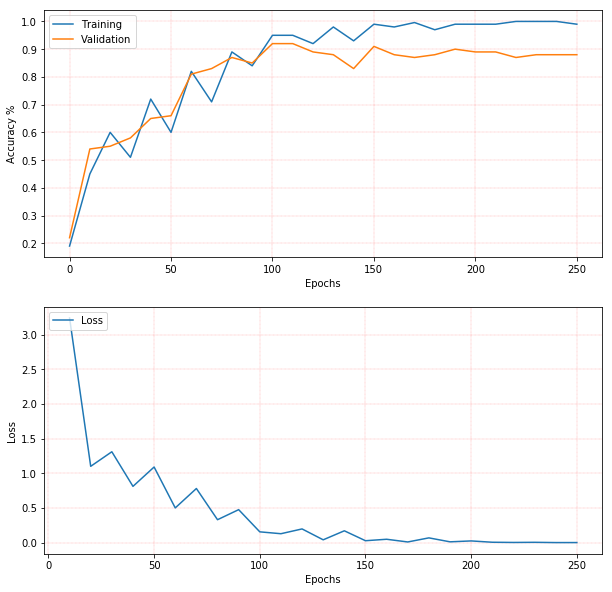

In [132]:
VGG_S_Net = loadNet(modelDir,dataDir,currNetDir,modelName)
plotTrainingHistory(train_acc,val_acc,iterations,loss)


Normalized confusion matrix
Test Accuracy : 75.2173913043 %


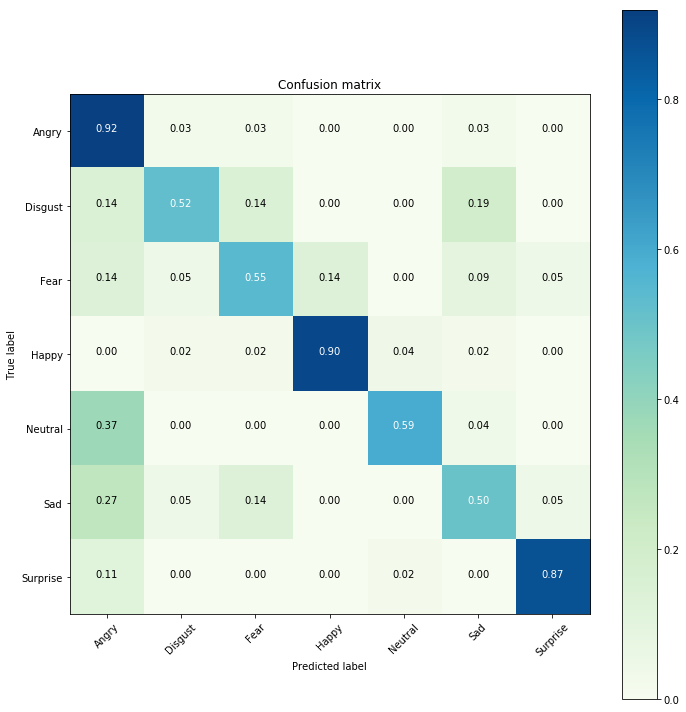

In [133]:
testDirPath = 'datasets/testing_images//'
confusion = testAccuracy(testDirPath)

In [134]:
#Comparing Accuracies of model snapshots at different epochs

# 420 Epoch
# CK+ Testing : 78.125%
# CK+ Training : 87.45%
# Jaffe Testing: 48.78%
# Jaffe Training : 61.627%
# Custom Test : 80%
# Custom Train : 70.29%
# All Test : 73.913%
# All Train : 73.75%

# 400 Epoch
# CK+ Testing : 78.125%
# CK+ Training : 87.07%
# Jaffe Testing: 57.55%
# Jaffe Training : 46.34%
# Custom Test : 83.2%
# Custom Train : 73.86%
# All Test : 75.217%
# All Train : 75.059%

# 300 Epoch
# CK+ Testing : 73.43%
# CK+ Training : 85.55%
# Jaffe Testing: 46.34%
# Jaffe Training : 55.23%
# Custom Test : 84.8%
# Custom Train : 74.25%
# All Test : 74.78%
# All Train : 74.8%

# 200 Epoch
# CK+ Testing : 82.81%
# CK+ Training : 81.7%
# Jaffe Testing: 41.4%
# Jaffe Training : 54.06%
# Custom Test : 81.6%
# Custom Train : 73.86%
# All Test : 74.7%
# All Train : 72.3%

#So, I am choosing the 400 epoch trained network.

In [135]:
def showimage(im):
    if im.ndim == 3:
        im = im[:, :, ::-1]
    plt.set_cmap('Blues')
    plt.imshow(im,vmin=0, vmax=0.2)
    

def vis_square(data, padsize=1, padval=0):
    data -= data.min()
    data /= data.max()
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = ((0, n ** 2 - data.shape[0]), (0, padsize), (0, padsize)) + ((0, 0),) * (data.ndim - 3)
    data = np.pad(data, padding, mode='constant', constant_values=(padval, padval))
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    showimage(data)

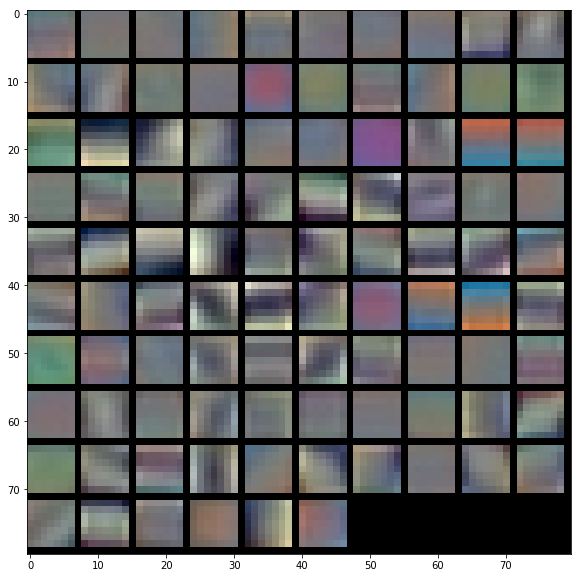

In [136]:
#Phase 1.5 : Checking Conv Layer Filters
filters = VGG_S_Net.params['conv1'][0].data
filters.shape
vis_square(filters.transpose(0, 2, 3, 1))

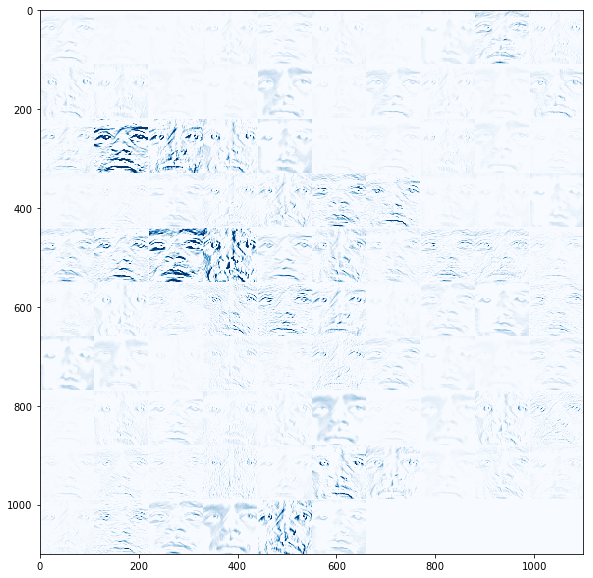

In [137]:
feat = VGG_S_Net.blobs['conv1'].data[0]
vis_square(feat)

In [138]:
#Phase 1.6 : Live Webcam Application
# Live webcam application

In [139]:
#Processes Frames and returns bounding box with prediction
font   = cv2.FONT_HERSHEY_TRIPLEX
fontScale   = 1.2
fontColor   = (0,255,0)
thickness   = 2
lineType    = 3

color = True
        
def processFrame(image):
    boundingboxes, points = face_detector.detect_face(image, minsize, PNet, RNet, ONet, threshold, True, factor)
    crops = []
    for box in range(boundingboxes.shape[0]):
        x1 = int(boundingboxes[box][0])
        y1 = int(boundingboxes[box][1])
        x2 = int(boundingboxes[box][2])
        y2 = int(boundingboxes[box][3])
        xd = int((x2-x1)*0)
        yd = int((y2-y1)*0)
        x11 = x1+xd
        x21 = x2-xd
        y11 = y1+yd
        y21 = y2-yd
        accuracy = boundingboxes[box][4]
        
        image2 = image.copy()
        cropped_img = image2[y11:y21, x11:x21]
        cropped_resized_img = cv2.resize(cropped_img, (256, 256))
        
        cropped_resized_img = toggleRGB(cropped_resized_img)
        cropped_resized_img = convertToGray(cropped_resized_img)
        cl1 = clahe.apply(cropped_resized_img)
        cl1 = threeChannel(cl1)
        crops.append(cl1)
        cl1 = cl1.astype(np.float32)
        cl1 /= 255.0
        prediction = VGG_S_Net.predict([cl1],oversample=False)
        p_i = prediction.argmax()        
        
        cv2.rectangle(image2, (x1, y1), (x2, y2), (0,255,0),2)
        cv2.putText(image2,str(categoriesEitW[p_i]) +" : "+ str(int(prediction[0][p_i]*100))+"%", 
        (x1+5,y2-5), 
        font, 
        fontScale,
        fontColor,
        thickness,
        lineType)
        
        image = image2

    return image,crops
        

In [ ]:
VGG_S_Net = loadNet(modelDir,dataDir,currNetDir,modelName)
cap = cv2.VideoCapture(0)
while(True):
    ret, frame = cap.read()
    frameb = frame
    if frame is None:
        continue
    frame = np.fliplr(frame)
    frame,crops = processFrame(frame)
    if frame is None:
        continue
    cv2.imshow('frame',frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()
cv2.waitKey(1)

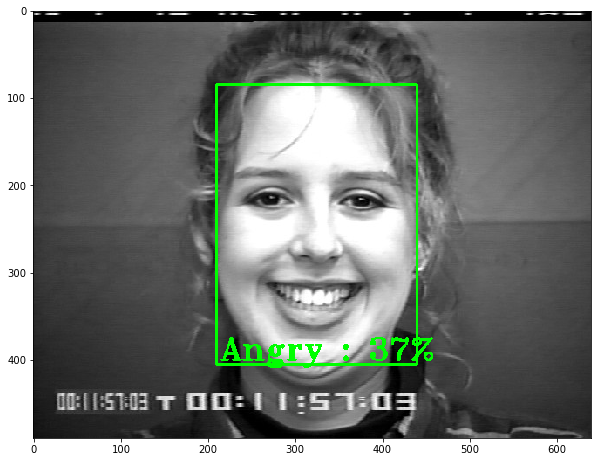

In [140]:
#Visualising some classifications
framee = cv2.imread('datasets/CKPlus/CKPlus_Images/S052/004/S052_004_00000011.png')
frame,s = processFrame(toggleRGB(framee))
plt.imshow(frame)